In [1]:
import os
import sys

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from IPython.display import display

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, parent_dir)

from src.dataloader import FastTensorDataLoader
from utils import FILES, load_samples, optimize_nonparametric

In [2]:
torch.set_default_dtype(torch.float64)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
file_selector = widgets.Dropdown(
    options=FILES,
    value=FILES[6],  # default
    description='Dataset:',
    layout=widgets.Layout(width='80%')
)

selected_filename = {"value": file_selector.value}

def on_file_change(change):
    if change["name"] == "value":
        selected_filename["value"] = change["new"]
        print(f"Selected file: {selected_filename['value']}")

file_selector.observe(on_file_change, names='value')
display(file_selector)

Dropdown(description='Dataset:', index=6, layout=Layout(width='80%'), options=('simulations/simulated_points_s…

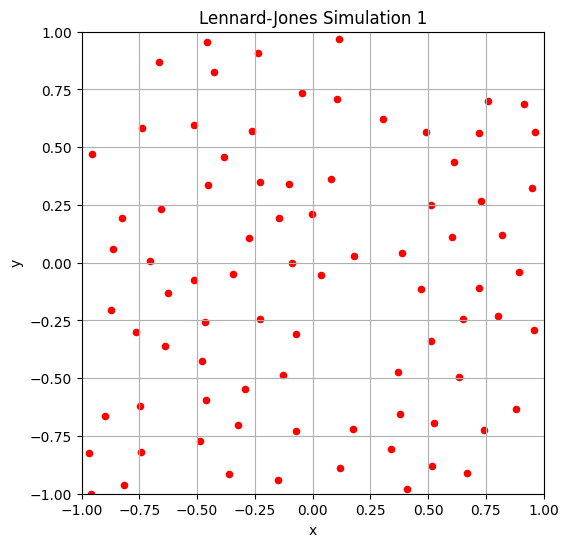

In [4]:
samples, scale, parameter, sigma, homogeneous, process = load_samples(selected_filename, device=device)
if process == "sftcr":
    k = parameter.clone()
else:
    epsilon = parameter.clone()
sim1 = samples[0].cpu()

plt.figure(figsize=(6, 6))
plt.scatter(sim1[:, 0], sim1[:, 1], color="red", s=20)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title("Softcore Simulation 1" if process == "sftcr" else "Lennard-Jones Simulation 1")
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect("equal")
plt.grid(True)
plt.show()

## Data Loader

In [5]:
test_size_widget = widgets.FloatSlider(
    value=0.2,
    min=0.0,
    max=0.9,
    step=0.05,
    description='Test size:',
    continuous_update=False,
    readout_format='.2f'
)

val_size_widget = widgets.FloatSlider(
    value=0.1,
    min=0.0,
    max=0.5,
    step=0.05,
    description='Val size:',
    continuous_update=False,
    readout_format='.2f'
)

batch_size_widget = widgets.IntSlider(
    value=32,
    min=1,
    max=512,
    step=1,
    description='Batch size:',
    continuous_update=False
)

display(test_size_widget, val_size_widget, batch_size_widget)

# Global storage
saved_params = {
    "test_size": test_size_widget.value,
    "val_size": val_size_widget.value,
    "batch_size": batch_size_widget.value,
    "loader_train": None,
    "loader_val": None,
    "loader_test": None
}

def on_widget_change(change):
    if change["name"] == "value":
        saved_params["test_size"] = test_size_widget.value
        saved_params["val_size"] = val_size_widget.value
        saved_params["batch_size"] = batch_size_widget.value

        total = len(samples)
        X = pad_sequence(samples, batch_first=True, padding_value=0)
        lengths = torch.tensor([len(s) for s in samples], dtype=torch.int64, device=device)
        lengths_expanded = lengths.unsqueeze(-1).expand(-1, X.shape[1])
        X = torch.cat((X, lengths_expanded.unsqueeze(-1)), dim=-1)

        m = len(X)

        # Calculate sizes
        m = len(X)
        test_cut = int(saved_params["test_size"] * m)
        remaining_size = m - test_cut
        val_size = max(1, round(saved_params["val_size"] * remaining_size))
        train_size = remaining_size - val_size
        
        X_train = X[:train_size]
        X_val   = X[train_size:train_size + val_size]
        X_rest  = X[train_size + val_size:]
        
        loader_train = FastTensorDataLoader(X_train, batch_size=saved_params["batch_size"], shuffle=False)
        loader_val   = FastTensorDataLoader(X_val,   batch_size=saved_params["batch_size"], shuffle=False)
        loader_rest  = FastTensorDataLoader(X_rest,  batch_size=saved_params["batch_size"], shuffle=False)

        saved_params["loader_train"] = loader_train
        saved_params["loader_val"] = loader_val
        saved_params["loader_rest"] = loader_rest

        print(f"[Updated] Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_rest)}, Batch: {saved_params['batch_size']}")

on_widget_change({"name": "value"})

# Attach observers
test_size_widget.observe(on_widget_change, names="value")
val_size_widget.observe(on_widget_change, names="value")
batch_size_widget.observe(on_widget_change, names="value")

FloatSlider(value=0.2, continuous_update=False, description='Test size:', max=0.9, step=0.05)

FloatSlider(value=0.1, continuous_update=False, description='Val size:', max=0.5, step=0.05)

IntSlider(value=32, continuous_update=False, description='Batch size:', max=512, min=1)

[Updated] Train: 7, Val: 1, Test: 2, Batch: 32


In [6]:
loader_train = saved_params["loader_train"]
loader_val = saved_params["loader_val"]
loader_test = saved_params["loader_test"]
batch_size = saved_params["batch_size"]
test_size = saved_params["test_size"]
val_size = saved_params["val_size"]

## Optimization function

In [7]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, activation=nn.Tanh, device='cpu'):
        super().__init__()
        self.device = device
        layers = []
        last_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(last_dim, h))
            layers.append(activation())
            last_dim = h
        layers.append(nn.Linear(last_dim, output_dim))
        self.net = nn.Sequential(*layers)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='tanh')

    def forward(self, x):
        return self.net(x)


class Gibbs_NN(nn.Module):
    def __init__(self, input_dim=2, hidden_dims=[24], output_dim=1, K=None, device='cpu'):
        super().__init__()
        torch.manual_seed(123)
        self.device = device
        self.K = K
        self.log_intensity_net = MLP(input_dim, hidden_dims, output_dim, device=device)
        self.potential_net = MLP(1, hidden_dims, output_dim, device=device)
        self.to(device)

    def log_intensity(self, positions):
        return self.log_intensity_net(positions)

    def potential(self, positions, mask):
        _, N, _ = positions.shape
        device = positions.device
    
        i_idx, j_idx = torch.triu_indices(N, N, offset=1, device=device)
        pairwise_mask = mask[:, i_idx] & mask[:, j_idx]
    
        xi, xj = positions[:, i_idx, :], positions[:, j_idx, :]
        diff = xi - xj
        
        r2 = torch.clamp(diff.pow(2).sum(dim=-1), min=1e-10)
        distances = r2.sqrt()
        distances = torch.where(pairwise_mask, distances, torch.tensor(0.0, device=device))

        return self.potential_net(distances.unsqueeze(-1))

    def compute_psi(self, positions, mask):
        positions = positions.to(self.device).requires_grad_()

        phi = self.potential(positions, mask)
        log_intensity = self.log_intensity(positions)

        grad_phi = torch.autograd.grad(
            phi, positions,
            grad_outputs=torch.ones_like(phi), create_graph=True, retain_graph=True
        )[0]

        grad_log = torch.autograd.grad(
            log_intensity, positions,
            grad_outputs=torch.ones_like(log_intensity), create_graph=True, retain_graph=True
        )[0]

        return grad_phi, grad_log

    def loss(self, positions):
        """
        positions: Tensor of shape (batch_size, max_length_positions, d) 
        """
        positions = positions.to(self.device)
        lengths = positions[:, 0, -1].to(dtype=torch.int64)
        max_length = lengths.max()
        x_t = positions[:, :max_length, :-1]
        mask = torch.arange(max_length, device=self.device).unsqueeze(0) < lengths.unsqueeze(1)
        
        psi_potential, psi_log_intensity = self.compute_psi(x_t, mask)
        
        norm_squared_potential = psi_potential.pow(2).sum(dim=-1) * mask
        # norm_squared_log_intensity = psi_log_intensity.pow(2).sum(dim=-1) * mask
        norm_squared_log_intensity = torch.zeros_like(norm_squared_potential)
    
        norm_squared = norm_squared_potential + norm_squared_log_intensity
    
        if self.K:
            divergence_potential = 0
            for _ in range(self.K):
                epsilon = torch.randint(0, 2, x_t.shape, device=x_t.device).float() * 2 - 1
                eps_psi = (psi_potential * epsilon).sum()
                divergence_est = torch.autograd.grad(
                    eps_psi, x_t, create_graph=True
                )[0]
                divergence_potential += (divergence_est * epsilon).sum(dim=-1) 
        else:
            divergence_potential = torch.zeros(x_t.shape[0], x_t.shape[1], device=x_t.device)
            for d in range(x_t.shape[-1]):
                for i in range(x_t.shape[-2]):
                    grad_potential = torch.autograd.grad(
                        psi_potential[:, i, d].sum(), x_t, retain_graph=True, create_graph=True
                    )[0][:, i, d]
                    divergence_potential[:, i] = grad_potential

        divergence_log_intensity = 0
        #for i in range(x_t.shape[-1]):
        #    grad_log = torch.autograd.grad(
        #        psi_log_intensity[..., i].sum(), x_t, retain_graph=True, create_graph=True
        #    )[0]
        #    divergence_log_intensity += grad_log[..., i]

        if self.K:
            divergence_potential_sum = (divergence_potential / self.K) * mask
        else:
            divergence_potential_sum = divergence_potential * mask
        divergence_log_intensity_sum = divergence_log_intensity * mask
    
        divergence = divergence_potential_sum + divergence_log_intensity_sum
    
        gibbs_loss = (0.5 * norm_squared + divergence).sum(dim=-1) / lengths
        return gibbs_loss.mean()

In [9]:
epochs = 250
results = optimize_nonparametric(
    loader_train, loader_val, Gibbs_NN, num_epochs=epochs, learning_rate=1e-3, device=device, K=None,
)

Training:   0%|          | 0/250 [00:30<?, ?epoch/s]


KeyboardInterrupt: 

In [58]:
model = results["model"]

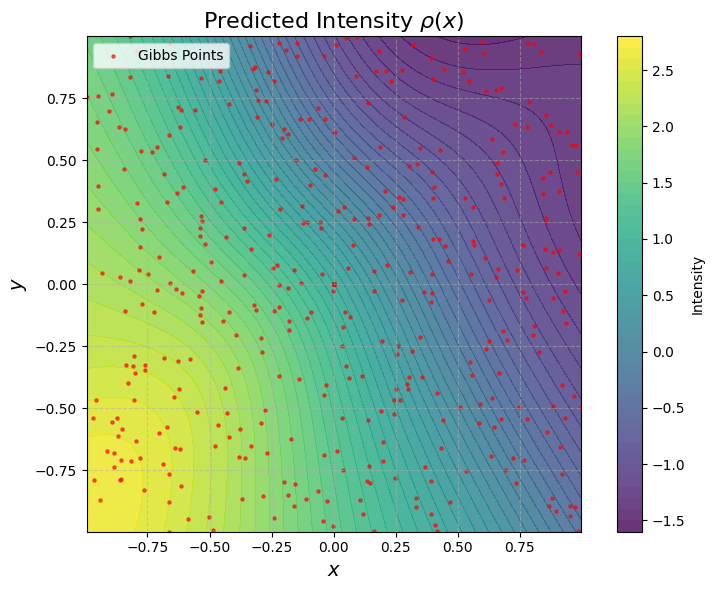

In [18]:
x = X_test[0][:, 0].cpu().numpy()
y = X_test[0][:, 1].cpu().numpy()

x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()

x_lin = np.linspace(x_min, x_max, 100)
y_lin = np.linspace(y_min, y_max, 100)
xx, yy = np.meshgrid(x_lin, y_lin)

grid_points = np.stack([xx.ravel(), yy.ravel()], axis=1)
grid_points_tensor = torch.tensor(grid_points, dtype=torch.float32).to(device)

intensity_pred = model.log_intensity(grid_points_tensor.unsqueeze(0)).detach().cpu().numpy()
intensity_pred_2d = intensity_pred.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(8, 6))

c = ax.contourf(xx, yy, intensity_pred_2d, levels=50, cmap='viridis', alpha=0.8)
ax.scatter(x, y, c='red', s=5, alpha=0.6, label='Gibbs Points')
ax.set_title(r'Predicted Intensity $\rho(x)$', fontsize=16)
ax.set_xlabel(r'$x$', fontsize=14)
ax.set_ylabel(r'$y$', fontsize=14)
ax.legend()
ax.set_aspect('equal')
ax.grid(True, linestyle='--', alpha=0.5)
fig.colorbar(c, ax=ax, label="Intensity")

plt.tight_layout()
plt.show()

In [70]:
def plot_potential_vs_true(model, d_min=0.1, d_max=0.5, num_points=500):
    """
    Plots learned potential vs. true softcore potential.
    
    model: trained Gibbs_Softcore instance
    sigma: softcore parameter
    k: softcore parameter
    d_min, d_max: range of distances
    num_points: number of distances to evaluate
    """
    model.eval()
    distances = torch.linspace(d_min, d_max, num_points, device=model.device).unsqueeze(-1)  # shape: (num_points, 1)

    learned_phi = model.potential_net(distances).squeeze()  # shape: (num_points,)

    r = distances.squeeze()
    if process == "lj":
        true_phi = 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6)
    else:
        true_phi = (sigma / r) ** (2 / k)

    # Create side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(12, 8))

    # Learned Potential
    axes[0].plot(r.cpu().numpy(), learned_phi.detach().cpu().numpy(), label='Learned φ(r)', lw=2)
    axes[0].set_title('Learned Potential')
    axes[0].set_xlabel('Distance r')
    axes[0].set_ylabel('Potential φ(r)')
    axes[0].grid(True)
    axes[0].legend()

    # True Potential
    axes[1].plot(r.cpu().numpy(), true_phi.cpu().numpy(), color='orange', label='True φ(r)', lw=2)
    axes[1].set_title('True Potential')
    axes[1].set_xlabel('Distance r')
    axes[1].set_ylabel('Potential φ(r)')
    axes[1].grid(True)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

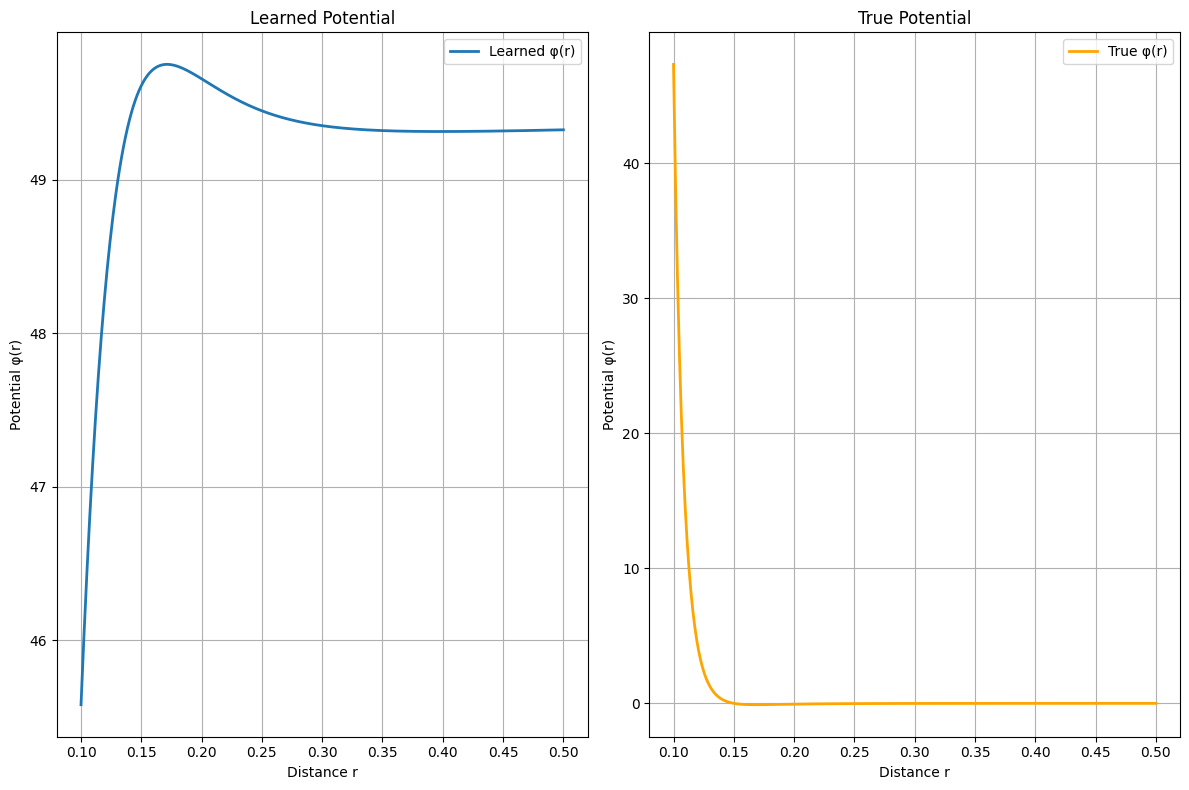

In [71]:
plot_potential_vs_true(model)

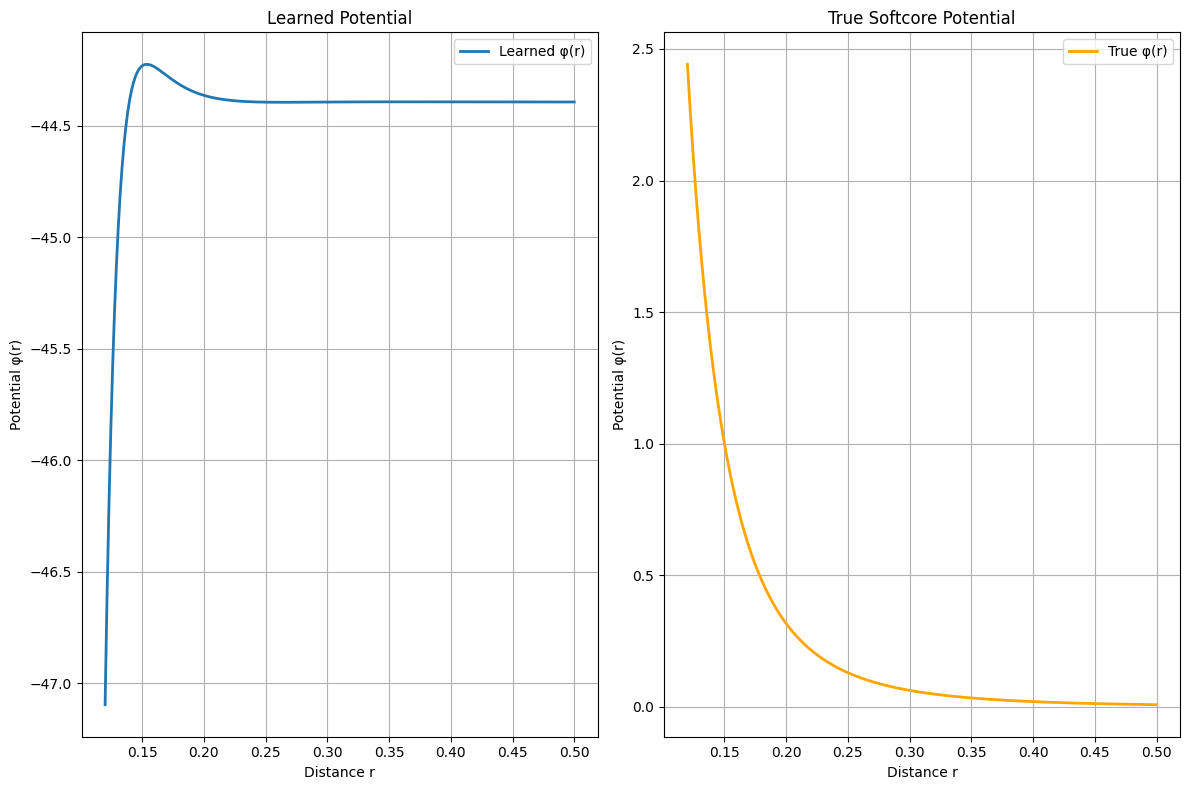

In [11]:
plot_potential_vs_true(model)

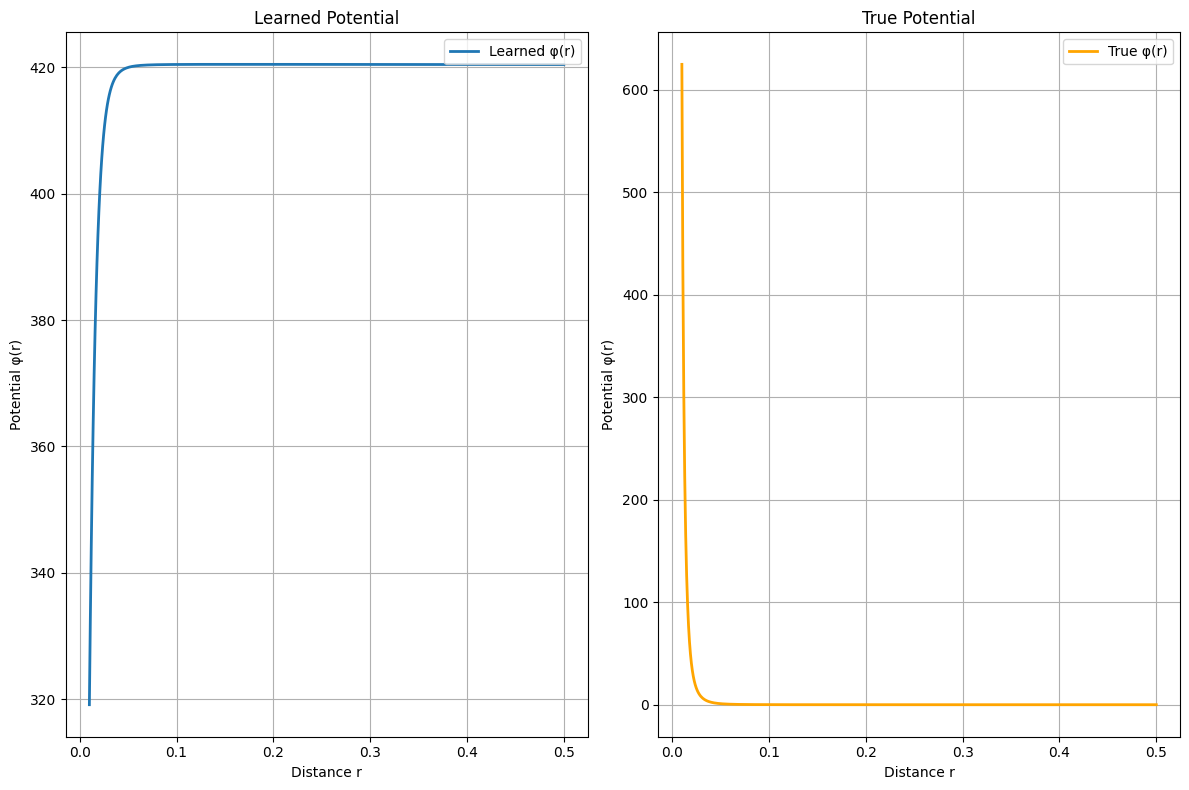

In [20]:
plot_potential_vs_true(model)

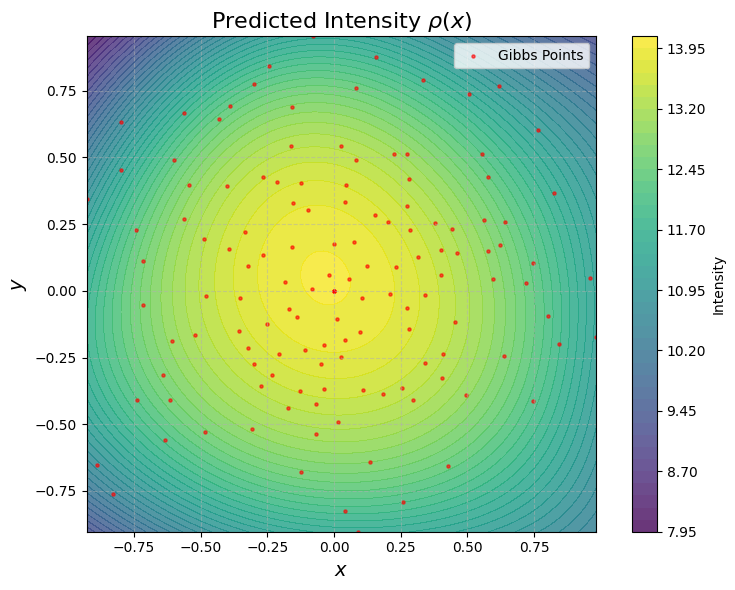

In [20]:
x = X_test[0][:, 0].cpu().numpy()
y = X_test[0][:, 1].cpu().numpy()

x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()

x_lin = np.linspace(x_min, x_max, 100)
y_lin = np.linspace(y_min, y_max, 100)
xx, yy = np.meshgrid(x_lin, y_lin)

grid_points = np.stack([xx.ravel(), yy.ravel()], axis=1)
grid_points_tensor = torch.tensor(grid_points, dtype=torch.float32).to(device)

intensity_pred = model.log_intensity(grid_points_tensor.unsqueeze(0)).detach().cpu().numpy()
intensity_pred_2d = intensity_pred.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(8, 6))

c = ax.contourf(xx, yy, intensity_pred_2d, levels=50, cmap='viridis', alpha=0.8)
ax.scatter(x, y, c='red', s=5, alpha=0.6, label='Gibbs Points')
ax.set_title(r'Predicted Intensity $\rho(x)$', fontsize=16)
ax.set_xlabel(r'$x$', fontsize=14)
ax.set_ylabel(r'$y$', fontsize=14)
ax.legend()
ax.set_aspect('equal')
ax.grid(True, linestyle='--', alpha=0.5)
fig.colorbar(c, ax=ax, label="Intensity")

plt.tight_layout()
plt.show()

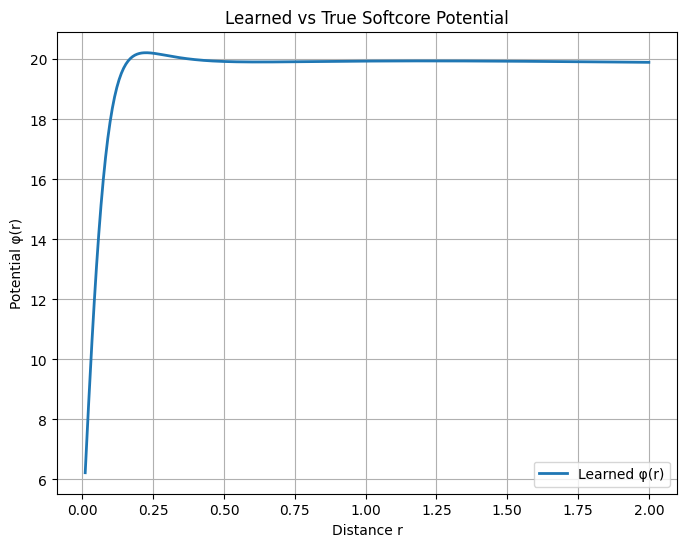

In [40]:
plot_potential_vs_true(model)

In [94]:
def plot_lambda_contributions_for_single_point(model, config_points, index_u):
    """
    Plot contribution of each other point v ∈ x \ u to λ(u | x \ u).

    Parameters:
        model: Trained Gibbs_Softcore model with .potential_net
        config_points: Tensor of shape (n_points, 2)
        index_u: Index of the point u in config_points to evaluate
    """
    model.eval()
    device = model.device
    config_points = config_points.to(device)

    u = config_points[index_u].unsqueeze(0)  # shape: (1, 2)
    rest = torch.cat([config_points[:index_u], config_points[index_u+1:]], dim=0)  # (n-1, 2)

    with torch.no_grad():
        dists = torch.cdist(u, rest).squeeze(0)  # shape: (n-1,)
        potentials = model.potential_net(dists.unsqueeze(1)).squeeze()  # shape: (n-1,)

        # Total potential for λ(u | x \ u)
        total_energy = potentials.sum()
        conditional_intensity = -total_energy.item()

    # Plot contributions
    plt.figure(figsize=(8, 5))
    plt.plot(range(len(potentials)), conditional_intensity.cpu().numpy(), color='steelblue')
    plt.xlabel('Other points (ordered)')
    plt.ylabel('Potential φ(||u - v||)')
    plt.title(f'Per-point contribution to λ(u | x \\ u), index_u = {index_u}\nTotal λ(u|x\\u) = {conditional_intensity:.4f}')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

In [95]:
x_config = X_test[0][:, :2]
x_config = x_config[x_config.abs().sum(dim=1) > 0]  # remove padded [0, 0] rows

plot_lambda_contributions_for_single_point(model, x_config, 10)

AttributeError: 'float' object has no attribute 'cpu'

<Figure size 800x500 with 0 Axes>